In [19]:
import os
import struct
from PIL import Image
import numpy as np

import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

from preprocess import extract_images
from dataset import get_full_list, ChineseCharacterDataset
from model import VAE, vae_loss, ConvVAE
from utils import visualize_images, show_images

In [20]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Preprocessing of dataset:

In [3]:
# # Only run it once is enough !!!
# gnt_dir = './dataset_gnt'
# output_dir = './dataset'
# extract_images(gnt_dir, output_dir)

In [4]:
# Set the directory and load the dataset
image_dir = './dataset'
full_data_list = get_full_list(image_dir)

# Create the full dataset
full_dataset = ChineseCharacterDataset(full_data_list)

# Define the subset sizes
total_size = len(full_dataset)
train_size = int(0.1 * total_size)
val_size = int(0.1 * total_size)
test_size = int(0.1 * total_size)

# Calculate the remaining size to be excluded
remaining_size = total_size - (train_size + val_size + test_size)

# Split the dataset into training, validation, test, and remaining sets
train_data_set, val_data_set, test_data_set, _ = random_split(\
    full_dataset, [train_size, val_size, test_size, remaining_size])

print("Training Set Size:", len(train_data_set))
print("Validation Set Size:", len(val_data_set))
print("Test Set Size:", len(test_data_set))

# Create data loaders
train_loader = DataLoader(train_data_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data_set, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data_set, batch_size=64, shuffle=False)

Training Set Size: 24357
Validation Set Size: 24357
Test Set Size: 24357


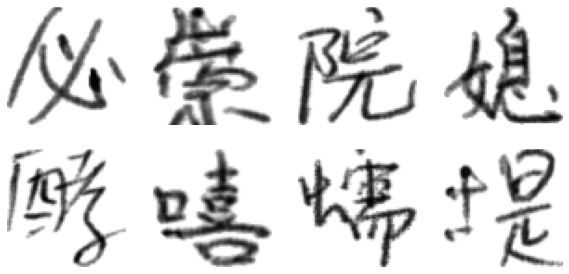

In [5]:
# Visualize images from the training set
visualize_images(train_loader, num_images=8)

### Training Loop:

In [28]:
# Train\
def train(model, train_data_set, input_dim, optimizer, scheduler, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch_idx, data in enumerate(train_data_set):
            data = data.view(-1, input_dim).to(device)
            optimizer.zero_grad()
            reconstructed_batch, mu, logvar = model(data)
            loss = vae_loss(reconstructed_batch, data, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
        scheduler.step()
        print(f'Epoch {epoch+1}, Loss: {train_loss/len(train_data_set.dataset)}')

### Hyperparameter Tuning:

In [ ]:
# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

In [1]:
from sklearn.model_selection import ParameterGrid

input_dim = 64 * 64

param_grid = {
    'z_dim': [50, 100, 200],
    'hidden_dim': [800, 1600, 3200],
    'learning_rate': [5e-4, 1e-4, 5e-5],
    'num_epochs': [50, 100],
    'batch_size': [16, 32],
}

grid = ParameterGrid(param_grid)

best_loss = float('inf')
best_params
.= None

for params in grid:
    model = VAE(input_dim, params['hidden_dim'], params['z_dim']).to(device)
    optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
    train_loader = DataLoader(train_data_set, batch_size=params['batch_size'], shuffle=True)
    train(model, train_loader, input_dim, optimizer, scheduler, params['num_epochs'])

    # Evaluate model performance
    model.eval()
    validation_loss = 0
    with torch.no_grad():
        for data in train_loader:
            data = data.view(-1, input_dim).to(device)
            reconstructed_batch, mu, logvar = model(data)
            loss = vae_loss(reconstructed_batch, data, mu, logvar)
            validation_loss += loss.item()
    
    validation_loss /= len(train_loader.dataset)
    if validation_loss < best_loss:
        best_loss = validation_loss
        best_params = params

print(f'Best params: {best_params}, Loss: {best_loss}')


### Generating Images:

In [35]:
best_params

{'batch_size': 16,
 'hidden_dim': 3200,
 'learning_rate': 0.0001,
 'num_epochs': 50,
 'z_dim': 50}

In [3]:
model = VAE(input_dim, best_params['hidden_dim'], best_params['z_dim']).to(device)
optimizer = optim.Adam(model.parameters(), lr=best_params['learning_rate'])
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
train_loader = DataLoader(train_data_set, batch_size=best_params['batch_size'], shuffle=True)
train(model, train_loader, input_dim, optimizer, scheduler, best_params['num_epochs']) 

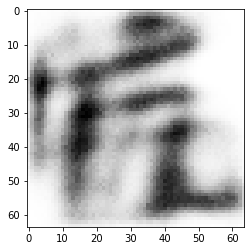

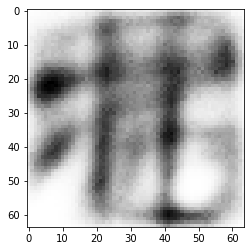

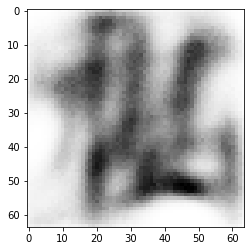

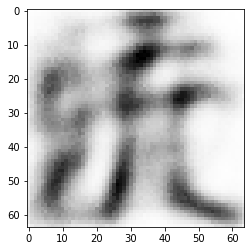

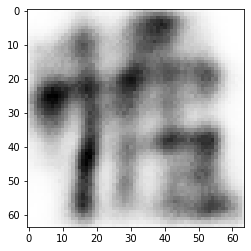

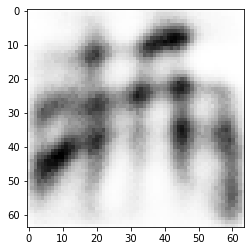

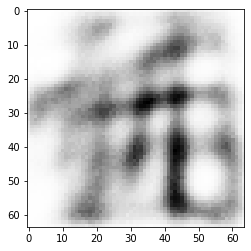

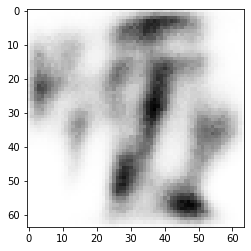

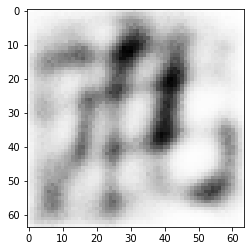

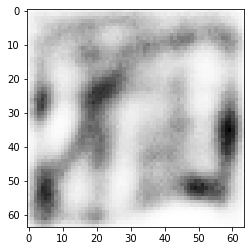

In [32]:
# Generating images
num_images = 10  # Number of images you want to generate
generated_images = model.generate(num_images)

for i in range(num_images):
    img = generated_images[i].cpu().detach().numpy().reshape(64, 64)
    plt.imshow(img, cmap='gray')
    plt.show()